<a href="https://colab.research.google.com/github/MoizAhmed2517/Time-Series-Forecasting-Projects/blob/main/GHI_Forecasting_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GHI Forecasting Neural Network

## Loading Libraries

In [117]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers

In [2]:
%cd /content/drive/MyDrive/ML Colabs/Dataset/Weather Data - NREL

/content/drive/MyDrive/ML Colabs/Dataset/Weather Data - NREL


In [3]:
!wget https://raw.githubusercontent.com/enerlytics-lab/Machine-learning-Models/Staging-Moiz/AFH_NREL_17-19.csv

--2023-07-26 09:44:28--  https://raw.githubusercontent.com/enerlytics-lab/Machine-learning-Models/Staging-Moiz/AFH_NREL_17-19.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-07-26 09:44:28 ERROR 404: Not Found.



In [4]:
df = pd.read_csv("/content/drive/MyDrive/ML Colabs/Dataset/Weather Data - NREL/AFH_NREL_17-19.csv", parse_dates=["datetime"], index_col=["datetime"])

In [5]:
df

,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Temperature,Relative Humidity,Solar Zenith Angle,Wind Direction,Wind Speed,Pressure,Cloud Type,Dew Point
datetime,,,,,,,,,,,,
2017-01-01 00:00:00,0,0,0,0,9.1,45.30,169.25,4,1.5,959,0,-2.1
2017-01-01 00:15:00,0,0,0,0,9.0,45.61,169.46,3,1.5,959,0,-2.1
2017-01-01 00:30:00,0,0,0,0,8.8,46.23,168.68,3,1.5,959,0,-2.1
2017-01-01 00:45:00,0,0,0,0,8.6,46.47,167.08,3,1.5,958,0,-2.2
2017-01-01 01:00:00,0,0,0,0,8.4,47.10,164.92,3,1.5,958,0,-2.2
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 22:45:00,0,0,0,0,6.2,59.29,158.56,86,0.8,965,0,-1.2
2019-12-31 23:00:00,0,0,0,0,6.3,58.89,161.35,86,0.7,965,1,-1.2
2019-12-31 23:15:00,0,0,0,0,6.4,58.48,163.97,83,0.7,965,1,-1.2


In [6]:
data = df.loc[:,['GHI']]

<Axes: xlabel='datetime'>

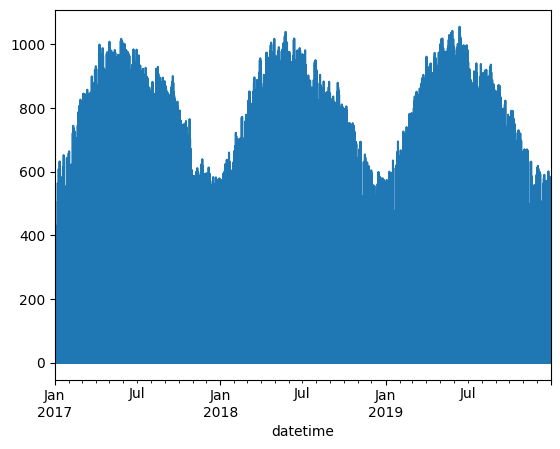

In [7]:
data['GHI'].plot()

## Preparing dataset for training

In [8]:
split_size = int(0.8 * len(data))
data.reset_index(inplace=True)
data

,datetime,GHI
0,2017-01-01 00:00:00,0
1,2017-01-01 00:15:00,0
2,2017-01-01 00:30:00,0
3,2017-01-01 00:45:00,0
4,2017-01-01 01:00:00,0
...,...,...
105115,2019-12-31 22:45:00,0
105116,2019-12-31 23:00:00,0
105117,2019-12-31 23:15:00,0
105118,2019-12-31 23:30:00,0


In [9]:
X = data.drop('GHI', axis=1)
y = data['GHI']

In [10]:
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

X_train = np.squeeze(X_train.to_numpy())
y_train = np.squeeze(y_train.to_numpy()).astype(np.float32)
X_test = np.squeeze(X_test.to_numpy())
y_test = np.squeeze(y_test.to_numpy()).astype(np.float32)

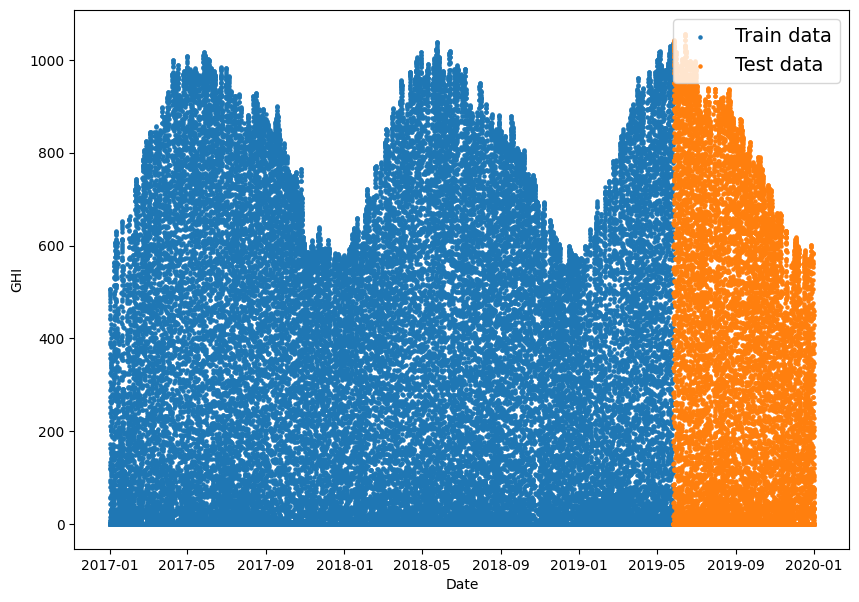

In [11]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("GHI")
plt.legend(fontsize=14)
plt.show();

### Making a baseline - Naive Forecasting

In [12]:
naive_forecast = y_test[:-1]

In [13]:
def timeSeries_plot(timeSteps, data, format=".", start=0, end=None, label=None):
  plt.plot(timeSteps[start:end], data[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

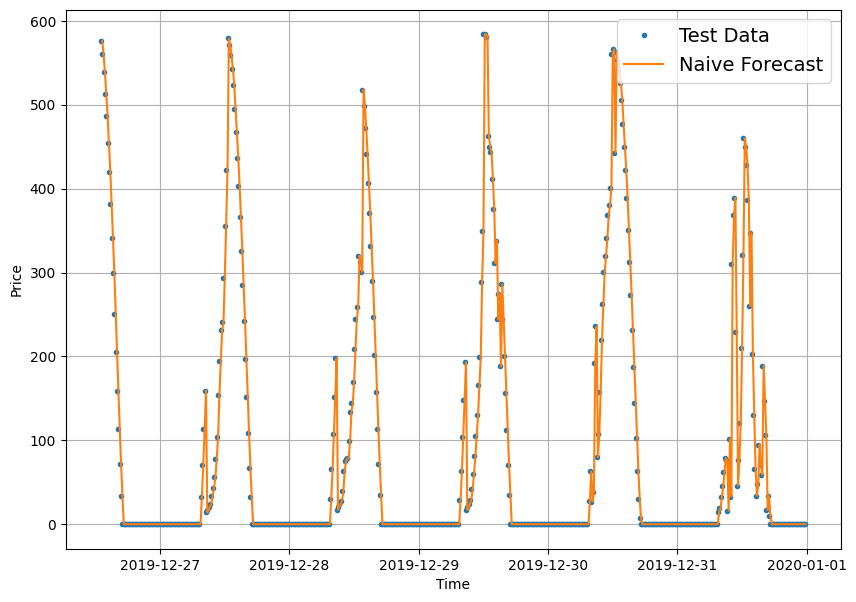

In [14]:
plt.figure(figsize=(10, 7))
offset = 20500
# timeSeries_plot(timeSteps=X_train, data=y_train, label="Test Data")
timeSeries_plot(timeSteps=X_test, data=y_test, start=offset, format=".", label="Test Data")
timeSeries_plot(timeSteps=X_test[1:], data=naive_forecast, start=offset, format="-", label="Naive Forecast")

In [15]:
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # Our seasonality is of 1 day
  return mae / mae_naive_no_season

def weighted_mean_absolute_percentage_error(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

def time_series_evaluation_metrics(y_true, y_pred):
  try:
    if y_pred.shape[1] > 1:
      mae = tf.reduce_mean(tf.keras.metrics.mean_absolute_error(y_true, y_pred))
      mse = tf.reduce_mean(tf.keras.metrics.mean_squared_error(y_true, y_pred))
      rmse = tf.reduce_mean(tf.sqrt(mse))
      mape = tf.reduce_mean(tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred))
      mase = tf.reduce_mean(mean_absolute_scaled_error(y_true, y_pred))
  except:
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    wmape = weighted_mean_absolute_percentage_error(y_true, y_pred)

  return {'MAE': mae.numpy(),
          'MSE': mse.numpy(),
          'RMSE': rmse.numpy(),
          'MAPE': mape.numpy(),
          'MASE': mase.numpy(),
          'WMAPE': wmape,
          }

In [16]:
naive_result = time_series_evaluation_metrics(y_true=y_test[1:], y_pred=naive_forecast)
naive_result

{'MAE': 21.689959,
 'MSE': 2207.07,
 'RMSE': 46.979465,
 'MAPE': 124007064.0,
 'MASE': 0.99995244,
 'WMAPE': 0.1089537}

### Timeseries Generator - Converting timeseries problem into supervised learning

In [17]:
HORIZON = 1
WINDOW = 7

In [85]:
input_data = y_train[:len(y_train)]
targets = y_train[WINDOW:]
generator = tf.keras.utils.timeseries_dataset_from_array(input_data, targets, sequence_length=WINDOW, batch_size=1)

In [87]:
#another way i will utilize in any another project for time being using previous methods
generator = tf.keras.utils.timeseries_dataset_from_array(
    input_data, targets, sequence_length=WINDOW, batch_size=1)

In [81]:
rand_data = np.random.randint(10, size=50)
input_data = rand_data[:len(rand_data)]
targets = rand_data[WINDOW:]

In [109]:
ghi = np.array(data['GHI'])
ghi

array([0, 0, 0, ..., 0, 0, 0])

In [89]:
def get_labelled_windows(data, horizon=HORIZON, window=WINDOW):
  """
  Create labels for windowed dataset.

  E.g.
  Input: [1, 2, 3, 4, 5, 6, 7, 8] -> Output: ([1, 2, 3, 4, 5, 6, 7], [8])
  """

  return data[:, :-horizon], data[:, -horizon:]

def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

def make_train_test_split(windows, labels, split=0.2):
  split_size = int(len(windows) * (1-split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [110]:
full_windows, full_labels = make_windows(ghi)

for i in range(3):
  try:
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")
  except:
    pass


Window: [0 0 0 0 0 0 0] -> Label: [0]
Window: [0 0 0 0 0 0 0] -> Label: [0]
Window: [0 0 0 0 0 0 0] -> Label: [0]


In [111]:
train_window, test_window, train_label, test_label = make_train_test_split(full_windows, full_labels)
len(train_window), len(test_window), len(train_label), len(test_label)

(84090, 21023, 84090, 21023)

In [115]:
#checking if y_train and train_label dataset are equal
np.array_equal(np.squeeze(train_label[:-HORIZON]), y_train[WINDOW:])

True

In [118]:
# Creating ModelCheckPoint Callback function

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

### Model:1 - ANN (Window = 7, horizon = 1)

In [122]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="Model")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

history_1 = model_1.fit(x=train_window,
                        y=train_label,
                        epochs=100,
                        verbose=1,
                        batch_size=128,
                        validation_data=(test_window, test_label),
                        callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
651/657 [============================>.] - ETA: 0s - loss: 17.7441 - mae: 17.7441 - mse: 2328.0056

657/657 [==============================] - 5s 5ms/step - loss: 17.7155 - mae: 17.7155 - mse: 2323.2288 - val_loss: 15.0110 - val_mae: 15.0110 - val_mse: 1945.2720
Epoch 2/100
652/657 [============================>.] - ETA: 0s - loss: 13.8696 - mae: 13.8696 - mse: 1836.4557

657/657 [==============================] - 3s 4ms/step - loss: 13.8695 - mae: 13.8695 - mse: 1837.1659 - val_loss: 14.7825 - val_mae: 14.7825 - val_mse: 1952.6257
Epoch 3/100
645/657 [============================>.] - ETA: 0s - loss: 13.6840 - mae: 13.6840 - mse: 1821.3585

657/657 [==============================] - 3s 5ms/step - loss: 13.7014 - mae: 13.7014 - mse: 1824.9106 - val_loss: 13.7962 - val_mae: 13.7962 - val_mse: 1925.5895
Epoch 4/100
645/657 [============================>.] - ETA: 0s - loss: 13.4632 - mae: 13.4632 - mse: 1806.9073

657/657 [==============================] - 2s 3ms/step - loss: 13.4977 - mae: 13.4977 - mse: 1810.5957 - val_loss: 13.6928 - val_mae: 13.6928 - val_mse: 1916.8647
Epoch 5/100
647/657 [============================>.] - ETA: 0s - loss: 13.2890 - mae: 13.2890 - mse: 1798.3872

657/657 [==============================] - 2s 3ms/step - loss: 13.2921 - mae: 13.2921 - mse: 1798.7042 - val_loss: 13.0283 - val_mae: 13.0283 - val_mse: 1895.2861
Epoch 6/100
657/657 [==============================] - 2s 2ms/step - loss: 13.2908 - mae: 13.2908 - mse: 1791.3168 - val_loss: 13.1740 - val_mae: 13.1740 - val_mse: 1890.8594
Epoch 7/100
657/657 [==============================] - ETA: 0s - loss: 13.2895 - mae: 13.2895 - mse: 1779.9995

657/657 [==============================] - 2s 4ms/step - loss: 13.2895 - mae: 13.2895 - mse: 1779.9995 - val_loss: 13.0217 - val_mae: 13.0217 - val_mse: 1863.1458
Epoch 8/100
657/657 [==============================] - 1s 2ms/step - loss: 13.1821 - mae: 13.1821 - mse: 1774.1552 - val_loss: 13.8538 - val_mae: 13.8538 - val_mse: 1878.5277
Epoch 9/100
657/657 [==============================] - 2s 4ms/step - loss: 13.1684 - mae: 13.1684 - mse: 1766.9219 - val_loss: 14.2915 - val_mae: 14.2915 - val_mse: 1887.6168
Epoch 10/100
644/657 [============================>.] - ETA: 0s - loss: 13.1571 - mae: 13.1571 - mse: 1764.2836

657/657 [==============================] - 3s 4ms/step - loss: 13.1355 - mae: 13.1355 - mse: 1761.9705 - val_loss: 12.8152 - val_mae: 12.8152 - val_mse: 1860.0923
Epoch 11/100
637/657 [============================>.] - ETA: 0s - loss: 13.0198 - mae: 13.0198 - mse: 1750.6447

657/657 [==============================] - 2s 3ms/step - loss: 13.0111 - mae: 13.0111 - mse: 1756.9596 - val_loss: 12.7367 - val_mae: 12.7367 - val_mse: 1852.1377
Epoch 12/100
657/657 [==============================] - 1s 2ms/step - loss: 13.0411 - mae: 13.0411 - mse: 1750.5035 - val_loss: 12.8602 - val_mae: 12.8602 - val_mse: 1839.2496
Epoch 13/100
657/657 [==============================] - 2s 2ms/step - loss: 13.1704 - mae: 13.1704 - mse: 1752.3115 - val_loss: 12.7390 - val_mae: 12.7390 - val_mse: 1833.1759
Epoch 14/100
657/657 [==============================] - 1s 2ms/step - loss: 13.0793 - mae: 13.0793 - mse: 1745.2006 - val_loss: 13.3402 - val_mae: 13.3402 - val_mse: 1835.0825
Epoch 15/100
640/657 [============================>.] - ETA: 0s - loss: 12.9859 - mae: 12.9859 - mse: 1745.7738

657/657 [==============================] - 2s 3ms/step - loss: 12.9883 - mae: 12.9883 - mse: 1741.9283 - val_loss: 12.7154 - val_mae: 12.7154 - val_mse: 1839.3979
Epoch 16/100
657/657 [==============================] - 2s 3ms/step - loss: 12.9346 - mae: 12.9346 - mse: 1737.6143 - val_loss: 13.1217 - val_mae: 13.1217 - val_mse: 1836.2527
Epoch 17/100
657/657 [==============================] - 2s 3ms/step - loss: 13.1599 - mae: 13.1599 - mse: 1736.4266 - val_loss: 14.9565 - val_mae: 14.9565 - val_mse: 1874.0076
Epoch 18/100
657/657 [==============================] - 2s 3ms/step - loss: 12.8735 - mae: 12.8735 - mse: 1730.1893 - val_loss: 12.7352 - val_mae: 12.7352 - val_mse: 1823.7664
Epoch 19/100
657/657 [==============================] - 2s 2ms/step - loss: 12.9622 - mae: 12.9622 - mse: 1729.3013 - val_loss: 12.8568 - val_mae: 12.8568 - val_mse: 1829.3915
Epoch 20/100
657/657 [==============================] - 2s 2ms/step - loss: 12.9063 - mae: 12.9063 - mse: 1727.5103 - val_loss: 12.90

657/657 [==============================] - 2s 4ms/step - loss: 12.8088 - mae: 12.8088 - mse: 1716.0192 - val_loss: 12.6660 - val_mae: 12.6660 - val_mse: 1831.6526
Epoch 25/100
657/657 [==============================] - 2s 3ms/step - loss: 12.8915 - mae: 12.8915 - mse: 1720.3851 - val_loss: 12.6858 - val_mae: 12.6858 - val_mse: 1812.1887
Epoch 26/100
657/657 [==============================] - 2s 3ms/step - loss: 12.9599 - mae: 12.9599 - mse: 1721.5876 - val_loss: 12.7881 - val_mae: 12.7881 - val_mse: 1814.8175
Epoch 27/100
657/657 [==============================] - 2s 2ms/step - loss: 12.8134 - mae: 12.8134 - mse: 1716.1064 - val_loss: 12.9207 - val_mae: 12.9207 - val_mse: 1821.4678
Epoch 28/100
657/657 [==============================] - 2s 2ms/step - loss: 12.8745 - mae: 12.8745 - mse: 1715.4747 - val_loss: 13.6710 - val_mae: 13.6710 - val_mse: 1835.9480
Epoch 29/100
657/657 [==============================] - 2s 2ms/step - loss: 12.8271 - mae: 12.8271 - mse: 1717.2316 - val_loss: 13.58

657/657 [==============================] - 2s 3ms/step - loss: 12.7768 - mae: 12.7768 - mse: 1711.8278 - val_loss: 12.5985 - val_mae: 12.5985 - val_mse: 1815.0045
Epoch 33/100
657/657 [==============================] - 2s 4ms/step - loss: 12.7421 - mae: 12.7421 - mse: 1710.1783 - val_loss: 12.6176 - val_mae: 12.6176 - val_mse: 1815.8649
Epoch 34/100
657/657 [==============================] - 2s 4ms/step - loss: 12.8260 - mae: 12.8260 - mse: 1710.3026 - val_loss: 12.8189 - val_mae: 12.8189 - val_mse: 1837.5696
Epoch 35/100
657/657 [==============================] - 2s 2ms/step - loss: 12.7657 - mae: 12.7657 - mse: 1710.4708 - val_loss: 14.6349 - val_mae: 14.6349 - val_mse: 1848.7905
Epoch 36/100
657/657 [==============================] - 2s 2ms/step - loss: 12.7099 - mae: 12.7099 - mse: 1706.4384 - val_loss: 12.6078 - val_mae: 12.6078 - val_mse: 1813.0790
Epoch 37/100
657/657 [==============================] - 1s 2ms/step - loss: 12.7261 - mae: 12.7261 - mse: 1703.4238 - val_loss: 12.68

657/657 [==============================] - 2s 3ms/step - loss: 12.7019 - mae: 12.7019 - mse: 1701.8995 - val_loss: 12.5712 - val_mae: 12.5712 - val_mse: 1798.1500
Epoch 44/100
657/657 [==============================] - 2s 2ms/step - loss: 12.6490 - mae: 12.6490 - mse: 1698.6758 - val_loss: 12.5917 - val_mae: 12.5917 - val_mse: 1813.3854
Epoch 45/100
657/657 [==============================] - 1s 2ms/step - loss: 12.6852 - mae: 12.6852 - mse: 1700.8264 - val_loss: 14.7435 - val_mae: 14.7435 - val_mse: 1831.0479
Epoch 46/100
657/657 [==============================] - 1s 2ms/step - loss: 12.6780 - mae: 12.6780 - mse: 1701.9717 - val_loss: 12.6045 - val_mae: 12.6045 - val_mse: 1827.3872
Epoch 47/100
657/657 [==============================] - 1s 2ms/step - loss: 12.7124 - mae: 12.7124 - mse: 1698.0403 - val_loss: 12.7501 - val_mae: 12.7501 - val_mse: 1793.2114
Epoch 48/100
657/657 [==============================] - 2s 2ms/step - loss: 12.6422 - mae: 12.6422 - mse: 1698.7950 - val_loss: 13.00

657/657 [==============================] - 3s 4ms/step - loss: 12.6925 - mae: 12.6925 - mse: 1696.8970 - val_loss: 12.5158 - val_mae: 12.5158 - val_mse: 1804.2300
Epoch 50/100
657/657 [==============================] - 2s 3ms/step - loss: 12.6403 - mae: 12.6403 - mse: 1697.7678 - val_loss: 12.5811 - val_mae: 12.5811 - val_mse: 1803.0154
Epoch 51/100
657/657 [==============================] - 2s 3ms/step - loss: 12.6197 - mae: 12.6197 - mse: 1692.9777 - val_loss: 13.4543 - val_mae: 13.4543 - val_mse: 1804.0657
Epoch 52/100
657/657 [==============================] - 1s 2ms/step - loss: 12.6908 - mae: 12.6908 - mse: 1697.2346 - val_loss: 13.6313 - val_mae: 13.6313 - val_mse: 1819.0521
Epoch 53/100
657/657 [==============================] - 1s 2ms/step - loss: 12.5955 - mae: 12.5955 - mse: 1690.8624 - val_loss: 12.5553 - val_mae: 12.5553 - val_mse: 1792.3958
Epoch 54/100
657/657 [==============================] - 2s 2ms/step - loss: 12.6283 - mae: 12.6283 - mse: 1692.7302 - val_loss: 12.58

657/657 [==============================] - 2s 3ms/step - loss: 12.4686 - mae: 12.4686 - mse: 1683.0112 - val_loss: 12.5048 - val_mae: 12.5048 - val_mse: 1799.1219
Epoch 80/100
657/657 [==============================] - 2s 2ms/step - loss: 12.4814 - mae: 12.4814 - mse: 1678.3204 - val_loss: 12.5155 - val_mae: 12.5155 - val_mse: 1811.8103
Epoch 81/100
657/657 [==============================] - 1s 2ms/step - loss: 12.4947 - mae: 12.4947 - mse: 1678.7921 - val_loss: 12.7717 - val_mae: 12.7717 - val_mse: 1788.0858
Epoch 82/100
657/657 [==============================] - 2s 2ms/step - loss: 12.5126 - mae: 12.5126 - mse: 1685.3450 - val_loss: 13.2956 - val_mae: 13.2956 - val_mse: 1791.2772
Epoch 83/100
657/657 [==============================] - 2s 4ms/step - loss: 12.5098 - mae: 12.5098 - mse: 1681.7954 - val_loss: 13.0425 - val_mae: 13.0425 - val_mse: 1787.4625
Epoch 84/100
657/657 [==============================] - 2s 3ms/step - loss: 12.4385 - mae: 12.4385 - mse: 1680.4659 - val_loss: 12.52

657/657 [==============================] - 2s 3ms/step - loss: 12.4044 - mae: 12.4044 - mse: 1674.4652 - val_loss: 12.4539 - val_mae: 12.4539 - val_mse: 1802.4318
Epoch 100/100
657/657 [==============================] - 2s 3ms/step - loss: 12.3909 - mae: 12.3909 - mse: 1674.1970 - val_loss: 12.4587 - val_mae: 12.4587 - val_mse: 1802.2783


In [123]:
model_1.evaluate(test_window, test_label)

657/657 [==============================] - 1s 2ms/step - loss: 12.4587 - mae: 12.4587 - mse: 1802.2784


[12.458678245544434, 12.458678245544434, 1802.2784423828125]

In [125]:
model_1 = tf.keras.models.load_model("model_experiments/Model")
model_1.evaluate(test_window, test_label)

657/657 [==============================] - 2s 2ms/step - loss: 12.4539 - mae: 12.4539 - mse: 1802.4303


[12.453866958618164, 12.453866958618164, 1802.4302978515625]

In [126]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [131]:
model_1_preds = make_preds(model_1, test_window)
len(model_1_preds), model_1_preds[1001]

657/657 [==============================] - 1s 2ms/step


(21023, <tf.Tensor: shape=(), dtype=float32, numpy=456.87>)

In [135]:
model_1_results = time_series_evaluation_metrics(y_true=tf.squeeze(tf.cast(test_label, tf.float32)), y_pred=model_1_preds)
model_1_results

{'MAE': 12.453866,
 'MSE': 1802.432,
 'RMSE': 42.45506,
 'MAPE': 47745132.0,
 'MASE': 0.57414925,
 'WMAPE': 0.06255861}